***Notebook con TODO el pipelene desde el inicio hasta el final***

**Instalamos dependencias**

In [ ]:
pip install sentence-transformers umap-learn scikit-learn matplotlib seaborn pandas numpy optuna plotly hdbscan

**Exploratory Analysis**

In [7]:
import pandas as pd
#Sentiment analysis en reddit comentarios
sentiment = "https://raw.githubusercontent.com/HiramZ04/Cal-State-UMAP_Clustering/refs/heads/main/data/sentiment_analysis.csv"
sentiment = pd.read_csv(sentiment)

#Call center calls
callrecordings = "https://raw.githubusercontent.com/HiramZ04/Cal-State-UMAP_Clustering/refs/heads/main/data/call_recordings.csv"
callrecordings = pd.read_csv(callrecordings)

In [8]:
callrecordings.head(5)

,id,Type,Sentiment,Name,Order Number,Product Number,Transcript
0,call_recording_01,Product Inquiry,Neutral,Sarah Miller,NaN,AC-7892,"Hello, I'm Sarah Miller. I'm calling to inquir..."
1,call_recording_02,Complaint,Angry,John Davis,123456.0,FR-4401,I am extremely dissatisfied with my recent ord...
2,call_recording_03,Technical Issue,Frustrated,Maria Rodriguez,987654.0,LAP-2110,"Hi, this is Maria Rodriguez. I'm having troubl..."
3,call_recording_04,Compliment,Happy,Robert Smith,246801.0,DW-6543,I just wanted to call and say how pleased I am...
4,call_recording_05,Order Placement,Neutral,Jessica Brown,NaN,OV-1357 & MW-8642,"Hello, my name is Jessica Brown. I'd like to p..."


In [9]:
callrecordings.shape

(20, 7)

**Preparamos el LLM para poder generar labels de 2 a 6 palabras para un transcript**

In [10]:
from ollama import chat
# We start passing a transcript to LLM
# We use gemma2:9b  

prompt_template = """
    You are a qualitative research analyst. Read one interview segment and produce EXACTLY ONE thematic label.

Requirements for the label:
- 2–6 words, concise and descriptive
- Neutral, observable phrasing (no opinions or causes)
- Title Case, no punctuation, no quotes
- Include at least one salient noun from the segment (e.g., product name, parameter, entity)


    Output Format:
    - ONLY 1 CODE and nothing else

    """

**Pasamos los transcripts de las entrevistas al LLM para que genere Thematic Labels**


In [11]:
# le pasamos las palabras al llm 
# CALL CENTER DATA SET

sentences_calls = callrecordings["Transcript"].astype(str).tolist()
    
labels_calls = []
GEN_OPTS = {"temperature": 0.0, "top_p": 1.0, "repeat_penalty": 1.2}

for i in range(len(sentences_calls)): 
# Pasamos el prompt con un system para que nos regrese el output que deseamos
    messages = [
        {
        'role':'system','content':prompt_template
        },
        {
        'role':'user', 'content':f'This is the transcript i need the codes for: {sentences_calls[i]}',
        },   
    ]

    label = chat(model = "gemma2:9b", messages=messages, options=GEN_OPTS)
    labels_calls.append(label['message']['content'])
    print("LLM response: ",label['message']['content'])

print("Lista completa de codes: ",labels_calls)


LLM response:  Product Feature Inquiry 

LLM response:  Damaged Refrigerator Complaint 

LLM response:  Laptop Connectivity Issues 

LLM response:  Customer Satisfaction DW-6543  

LLM response:  Customer Order Inquiry 

LLM response:  Wireless Speaker Functionality 

LLM response:  Order Delivery Delay 

LLM response:  Router Network Setup 

LLM response:  Customer Order Inquiry 

LLM response:  Customer Satisfaction With PR9876  

LLM response:  Technical Data Request 

LLM response:  Color Discrepancy Concern  

LLM response:  System Outage Impact 

LLM response:  Product Inquiry Weekend Delivery 

LLM response:  Customer Satisfaction With CAMERA-PRO-1 

LLM response:  Tablet Functionality Inquiry 

LLM response:  WasherDryer Combo Malfunction 

LLM response:  Software Suite Pro Installation Issues 

LLM response:  Office Furniture Procurement 

LLM response:  Customer Satisfaction With Television  

Lista completa de codes:  ['Product Feature Inquiry \n', 'Damaged Refrigerator Comp

**Vectoriziamos estos thematic labels a high dimention**

In [13]:
# Despues de generar los thematic labels vectorizamos y hacemos cluster con HBDSCAN
from sentence_transformers import SentenceTransformer

ST_model = SentenceTransformer('all-MiniLM-L6-v2')
sentiment_embedded = ST_model.encode(labels_calls, convert_to_numpy=True)

print(sentiment_embedded)
len(sentiment_embedded)

[[ 0.00366069 -0.00752952  0.06497706 ...  0.01899537  0.02277697
   0.02060767]
 [-0.08998163  0.07875953  0.03396311 ... -0.03865698  0.01800763
   0.06707014]
 [-0.00937285  0.01847781  0.03660005 ... -0.02829518 -0.06054836
  -0.08074775]
 ...
 [ 0.02849676 -0.0457797   0.0915461  ... -0.07369266  0.02658791
  -0.06481579]
 [-0.03448592  0.0323069  -0.01390294 ... -0.05362167  0.01045971
   0.02731554]
 [ 0.00285943 -0.01795875  0.00211081 ...  0.00066171 -0.0242996
  -0.00756753]]


20

**Graficamos el embbedded space**

In [15]:
# Requisitos: sentiment_embedded (np.ndarray n×d) y labels_sentiment (list[str] de largo n)

import numpy as np
import pandas as pd
import plotly.express as px
from umap import UMAP

# Seguridad: que coincidan tamaños
assert len(labels_calls) == sentiment_embedded.shape[0], "Dim mismatch"

# Reducir a 2D solo para visualizar
X2 = UMAP(n_components=2, metric="cosine", random_state=42).fit_transform(sentiment_embedded)

# DataFrame para el plot (incluye 'code' = tus labels)
df_plot = pd.DataFrame({
    "x1": X2[:, 0],
    "x2": X2[:, 1],
    "code": [str(c) if c is not None else "" for c in labels_calls],
})

fig = px.scatter(
    df_plot, x="x1", y="x2",
    hover_data=["code"]   # <-- aquí se ve el label en el hover
)
fig.update_layout(xaxis_title="x1", yaxis_title="x2")
fig.show()


c:\Users\Hiram\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


**Implementamos optuna para el HDBSCAN con la metrica topic coherence para evaluar** 

**Clusterizamos con HBDSCAN en high dimention y graficamos el cluster**

In [20]:
from hdbscan import HDBSCAN
from sklearn.preprocessing import normalize
import pandas as pd
import plotly.express as px


hdb = HDBSCAN(min_cluster_size=2, min_samples=1 ).fit(sentiment_embedded)
labels = hdb.labels_


print(labels)



df_plot = pd.DataFrame({
    "x1": X2[:, 0],           # reusa la proyeccion 2D de la celda anterior
    "x2": X2[:, 1],
    "cluster": labels,    # −1 = ruido
    "code": labels_calls
})

# opcion: mostrar "noise" en la leyenda
df_plot["cluster_str"] = df_plot["cluster"].astype(str).replace({"-1": "noise"})

fig = px.scatter(
    df_plot, x="x1", y="x2",
    color="cluster_str",               # o usa "cluster" si prefieres numerico
    hover_data=["code"],
    color_discrete_sequence=px.colors.qualitative.Plotly
)
fig.update_layout(
    xaxis_title="x1", yaxis_title="x2",
    legend_title_text="cluster",
    legend=dict(orientation="h", yanchor="bottom", y=-0.25, xanchor="center", x=0.5)
)
fig.show()




[ 1 -1  0  2  1 -1  1  0  1  2 -1 -1  0  1  2 -1 -1 -1 -1  2]


c:\Users\Hiram\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\Hiram\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



**le pedimos al LLM labels para los clusters**

In [22]:
# === Theme naming por cluster con Ollama ===
# Requiere: labels_sentiment (list[str]) y labels_hdb (np.ndarray o list[int])
# Salida: df_cluster_themes (tabla con nombres) y cluster_name_por_fila (list[str])

import json, random
import pandas as pd
from collections import defaultdict
from ollama import chat

MODEL = "gemma2:9b"   # o "gemma2:9b"
GEN_OPTS = {
    "temperature": 0.0,
    "top_p": 1.0,
    "repeat_penalty": 1.2,
    "num_predict": 96,   # suficiente para nombre + definición
}

SYSTEM_PROMPT = """
You are a qualitative research analyst.
Given several short codes that belong to ONE cluster, propose:
- a concise cluster name (2–5 words, Title Case, no punctuation),
- a one-sentence definition describing the common theme.

Return STRICT JSON in ONE line:
{"cluster_name":"<2-5 words>", "definition":"<one sentence>"}
Do not include any extra text.
"""

def sample_codes(codes, k=12):
    """muestra sin repetidos (hasta k)"""
    uniq = list(dict.fromkeys([c.strip() for c in codes if str(c).strip()]))
    if len(uniq) <= k:
        return uniq
    return random.sample(uniq, k)

def ask_theme_ollama(codes_sample):
    # pasa los codes como bullets para que el LLM vea variedad
    bullets = "\n".join(f"- {c}" for c in codes_sample)
    user = f"Here are representative codes from one cluster:\n{bullets}\n\nReturn JSON only."
    resp = chat(
        model=MODEL,
        messages=[{"role":"system","content":SYSTEM_PROMPT},
                  {"role":"user","content":user}],
        options=GEN_OPTS,
        keep_alive=-1,
    )
    txt = resp["message"]["content"].strip()
    # intenta parsear JSON
    try:
        data = json.loads(txt)
        name = str(data.get("cluster_name","")).strip()
        definition = str(data.get("definition","")).strip()
        if not name:
            name = "Unnamed Theme"
        if not definition:
            definition = "No definition provided."
        return name, definition, txt
    except json.JSONDecodeError:
        # fallback: usa el texto completo como nombre
        return txt[:60], "LLM returned non-JSON; truncated as name.", txt

# --- agrupa codes por cluster ---
codes_por_cluster = defaultdict(list)
for lab, clu in zip(labels_calls, labels):
    if clu == -1:
        continue  # omite ruido
    codes_por_cluster[int(clu)].append(lab)

# --- pide nombre/definición por cluster ---
rows = []
for clu_id, codes_list in sorted(codes_por_cluster.items()):
    sample = sample_codes(codes_list, k=12)
    name, definition, raw = ask_theme_ollama(sample)
    rows.append({
        "cluster_id": clu_id,
        "n_items": len(codes_list),
        "sampled_codes": sample,
        "cluster_name": name,
        "definition": definition,
        "raw_llm": raw,      # por si quieres inspeccionar lo que devolvió
    })

df_cluster_themes = pd.DataFrame(rows).sort_values("cluster_id").reset_index(drop=True)
print(df_cluster_themes[["cluster_id","n_items","cluster_name"]])

# --- mapea nombre a cada fila (alineado a labels_hdb) ---
name_map = {row.cluster_id: row.cluster_name for _, row in df_cluster_themes.iterrows()}
cluster_name_por_fila = [name_map.get(int(c), "noise") if c != -1 else "noise" for c in labels]

# Ejemplo: si tienes un DataFrame con tus puntos, añade la columna
# df_plot["cluster_name"] = cluster_name_por_fila

# Guarda opcional
# df_cluster_themes.to_csv("cluster_themes.csv", index=False, encoding="utf-8-sig")


   cluster_id  n_items               cluster_name
0           0        3     Technical Difficulties
1           1        5  Customer Service Requests
2           2        4      Customer Satisfaction


**Graficamos los clusters con nombre**

In [24]:
# pip install umap-learn plotly
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from umap import UMAP

# 1) Proyección a 2D (solo para visualizar)
X2 = UMAP(n_components=2, metric="cosine", random_state=42).fit_transform(sentiment_embedded)

# 2) Construye la lista de nombres de tema por punto
if 'cluster_name_por_fila' in globals():
    themes = cluster_name_por_fila  # ya la tienes de la celda anterior
else:
    # map desde df_cluster_themes
    name_map = {int(r.cluster_id): r.cluster_name for _, r in df_cluster_themes.iterrows()}
    themes = [name_map.get(int(c), "noise") if c != -1 else "noise" for c in labels_hdb]

# 3) DataFrame para plotear
df_plot = pd.DataFrame({
    "x1": X2[:, 0],
    "x2": X2[:, 1],
    "theme": themes,                 # nombre del cluster
    "code": labels_calls,        # tu label/código por punto
})

# 4) Scatter coloreado por tema con hover (code + theme)
fig = px.scatter(
    df_plot, x="x1", y="x2",
    color="theme",
    hover_data=["code", "theme"],
    color_discrete_sequence=px.colors.qualitative.Plotly
)

# (Opcional) Si quieres que el "ruido" se llame noise siempre:
# df_plot["theme"] = df_plot["theme"].astype(str)

fig.update_layout(
    xaxis_title="x1", yaxis_title="x2",
    legend_title_text="Themes",
    legend=dict(orientation="h", yanchor="bottom", y=-0.25, xanchor="center", x=0.5)
)



fig.show()


c:\Users\Hiram\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



**Implementamos Optuna para hiperparametros de UMAP y Clustering**

In [ ]:
# Implementamos Optuna para mejorar hiperparametros:
import numpy as np
import pandas as pd
import optuna
import umap.umap_ as umap
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from tabulate import tabulate
import optuna


# Defino funcion trial donde busco los mejores hiperparametros simultaneamente de UMAP y AgglomerativeClustering ya que los 2 son simultaneos y se afectan el uno al otro

def objective(trial):
    # Definimos HiperParametros
    min_dist = trial.suggest_float('min_dist', 0.0465, 0.049)    # UMAP
    n_neighbors = trial.suggest_int('n_neighbors', 2, 3) # UMAP
    n_clusters = trial.suggest_int('n_clusters', 10, 13)  # Agglomerative Clustering
    agg_linkage = trial.suggest_categorical('agg_linkage', ['average', 'complete']) # Agglomerative Clustering

    # UMAP
    umap_model = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_dist, n_components = 2, metric = 'cosine', random_state=24)
    low_dimension_words = umap_model.fit_transform(sentiment_embedded)

    # Clustering
    clustering_model = AgglomerativeClustering(n_clusters = n_clusters, linkage = agg_linkage, metric = 'cosine')
    clusters = clustering_model.fit_predict(low_dimension_words)

    # Silhoutte Score
    s_score = silhouette_score(low_dimension_words, clusters, metric='cosine')

    return s_score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

study.best_params

**Ahora reducimos a 2 dimensiones con UMAP y aplicamos Agglomerative Clustering a los labels generados por LLM**

In [42]:
# Ahora implementamos Silhoutte score para los hiperparametros optimizados
# Con los parametros que se eligieron siempre se tiene un score mejor a 0.93 y promedia el 0.95

import numpy as np
import pandas as pd
import optuna
import umap.umap_ as umap
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from tabulate import tabulate


umap_optimized = umap.UMAP(n_neighbors = 2, min_dist= 0.048 , n_components=2, metric = 'cosine')
low_dimension_opt = umap_optimized.fit_transform(sentiment_embedded)

clustering_model_opt = AgglomerativeClustering(n_clusters = 10, linkage='complete', metric='cosine')
clusters_opt = clustering_model_opt.fit_predict(low_dimension_opt)

table_opt = np.column_stack((labels_calls,clusters_opt))
print(tabulate(table_opt[:5] ,headers=('Words','Clusters'), tablefmt ='fancy_grid'))

s_opt = silhouette_score(low_dimension_opt, clusters_opt, metric='cosine')
print(f'Current Silhouette Coefficient s = {s_opt:.2f}')


╒════════════════════════════════╤════════════╕
│ Words                          │   Clusters │
╞════════════════════════════════╪════════════╡
│ Product Feature Inquiry        │          9 │
├────────────────────────────────┼────────────┤
│ Damaged Refrigerator Complaint │          3 │
├────────────────────────────────┼────────────┤
│ Laptop Connectivity Issues     │          0 │
├────────────────────────────────┼────────────┤
│ Customer Satisfaction DW-6543  │          6 │
├────────────────────────────────┼────────────┤
│ Customer Order Inquiry         │          8 │
╘════════════════════════════════╧════════════╛
Current Silhouette Coefficient s = 0.64


**Graficamos los clusters en 2 Dimensiones**

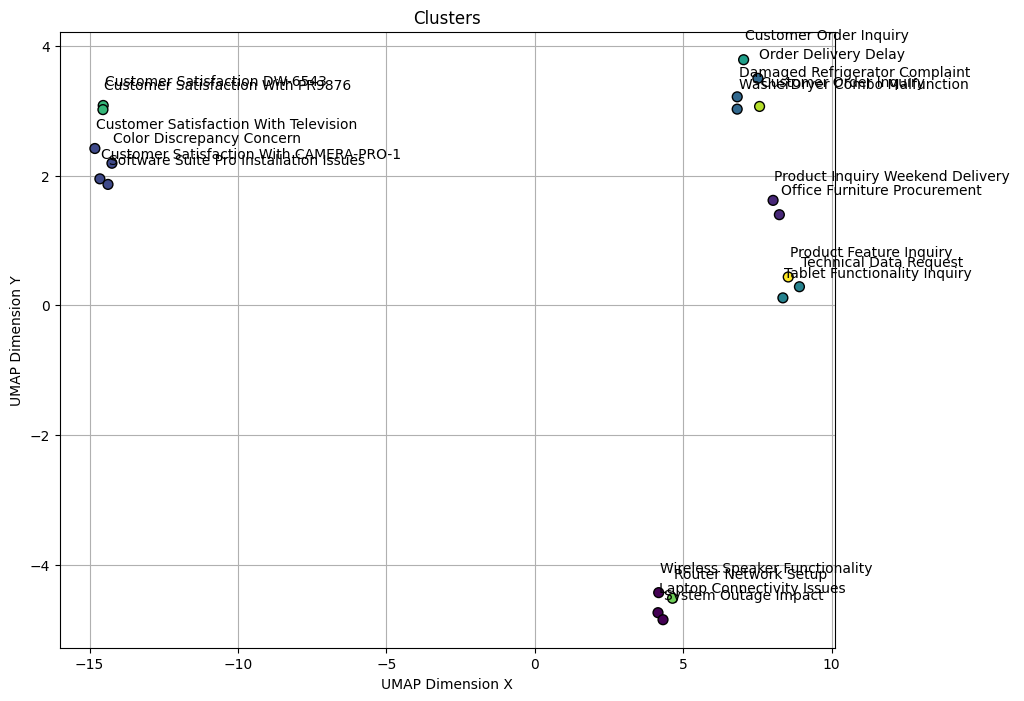

In [43]:
# Graficamos el Scatter Plot de los clusters

plt.figure(figsize=(10,8))
plt.grid(True)
plt.scatter(low_dimension_opt[:,0],low_dimension_opt[:,1],c=clusters_opt,s=50,edgecolor='k',zorder=2)
plt.xlabel("UMAP Dimension X")
plt.ylabel("UMAP Dimension Y")
plt.title("Clusters")
for xi, yi, w in zip(low_dimension_opt[:,0],low_dimension_opt[:,1],labels_calls):
  plt.annotate(w, (xi,yi),xytext=(1, 3), textcoords="offset points")
plt.show()

**Graficamos un primer dendograma sin labels en las intersecciones**

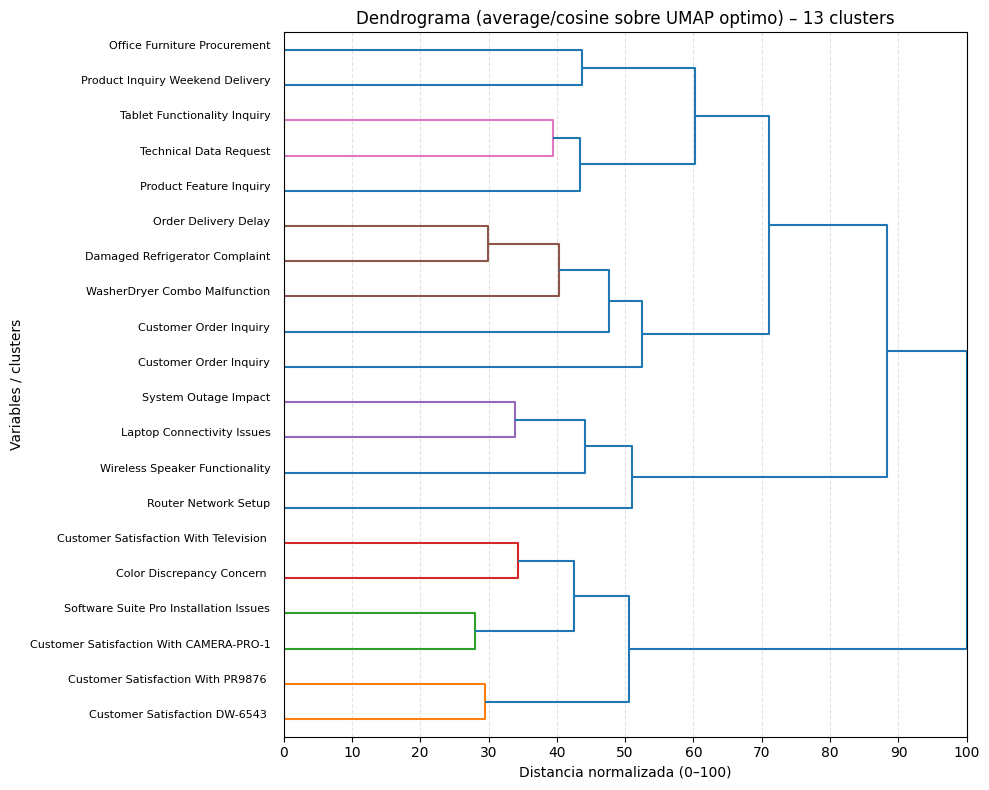

In [45]:
# Graficamos el Dendrograma usando matplotlib 

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import matplotlib.pyplot as plt

k = 13  # El numero de clusters que utilizamos

model = AgglomerativeClustering(
    distance_threshold=0, n_clusters=None,
    linkage='average', metric='cosine',
    compute_distances=True
).fit(low_dimension_opt)  


n = len(model.labels_)
counts = np.zeros(model.children_.shape[0])
for i, merge in enumerate(model.children_):
    cnt = 0
    for m in merge:
        cnt += 1 if m < n else counts[m - n]
    counts[i] = cnt

dist = model.distances_.copy()
dist = np.power(dist, 0.1)          
dist = (dist / dist.max()) * 100.0  

Z = np.column_stack([model.children_, dist, counts]).astype(float)


t = n - k
color_th = dist[t]

plt.figure(figsize=(10, 8))  # mas alto que ancho
dendrogram(
    Z,
    labels=labels_calls,
    orientation='right',      # <- antes estaba 'top'
    leaf_font_size=8,
    color_threshold=color_th,
    distance_sort='ascending'
)

plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10))
plt.grid(axis='x', linestyle='--', alpha=0.35)
plt.title(f'Dendrograma (average/cosine sobre UMAP optimo) – {k} clusters')
plt.xlabel('Distancia normalizada (0–100)')
plt.ylabel('Variables / clusters')
plt.tight_layout()
plt.show()


**Pedimos a nuestro LLM local (cal-state-words) labels para las intersecciones del dendograma**

In [47]:
# Intentamos lo mismo pero con nuestro custom model y vemos que palabras nos da:

from sklearn.cluster import AgglomerativeClustering
import numpy as np
from ollama import chat


children = model.children_.astype(int)
n = len(labels_calls)

node_label = [None] * (n + (n - 1)) # creamos la lista donde guardaremos TODAS las palabras para no tener problemas de index < 50

# vamos a inicializar con la lista de palabras que yo tengo y se le iran agregando las fusiones
for j in range(n):
    node_label[j] = labels_calls[j]


for i in range(Z.shape[0]):
   left = int(Z[i, 0])    # el nodo izq es en posicion 0 de la matriz Z
   right = int(Z[i, 1])   # el nodo der es en posicion 1 de la matriz Z
   new = n + i            # cada nodo interno o palabra nueva creada por interseccion esta en el indice n (50) + i que es la posicion en la que vamos

# Si ya existen las palabras las va a buscar en mi lista de palabras indexada 
   left_word = node_label[left]  
   right_word = node_label[right]

# Le pedimos al LLM local que cree la palabra en base a 2 palabras de esta manera siempre tendremos una palabra para poder usar
# en vez de tener un par como garden + flower tenemos together o en vez de tener internal node 69 ya tienes la palabra generada por el LLM
   messages = [
        {"role":"user","content":f"This is my list of words: {left_word} and {right_word}"}   
    ]
   resp  = chat(model="cal-state_words:latest", messages=messages)
   label = resp["message"]["content"] 

   # La palabra nueva que genero el LLM para la fusions va en la lista node label en la posicion n (50) mas el i 
   node_label[new] = label 
   print(f"fusion {i}: ({left_word} + {right_word}) -> {label}")

print("\nEsta es la lista final de palabras que le podemos pasar al dendograma para que las etiquete: \n", node_label)




fusion 0: (Customer Satisfaction With CAMERA-PRO-1 
 + Software Suite Pro Installation Issues 
) -> Feedback
fusion 1: (Customer Satisfaction DW-6543  
 + Customer Satisfaction With PR9876  
) -> Feedback
fusion 2: (Damaged Refrigerator Complaint 
 + Order Delivery Delay 
) -> Warranty
fusion 3: (Laptop Connectivity Issues 
 + System Outage Impact 
) -> Network
fusion 4: (Color Discrepancy Concern  
 + Customer Satisfaction With Television  
) -> Feedback
fusion 5: (Technical Data Request 
 + Tablet Functionality Inquiry 
) -> Support
fusion 6: (WasherDryer Combo Malfunction 
 + Warranty) -> Coverage
fusion 7: (Feedback + Feedback) -> Response
fusion 8: (Product Feature Inquiry 
 + Support) -> Feedback
fusion 9: (Product Inquiry Weekend Delivery 
 + Office Furniture Procurement 
) -> Orders
fusion 10: (Wireless Speaker Functionality 
 + Network) -> Audio
fusion 11: (Customer Order Inquiry 
 + Coverage) -> Feedback
fusion 12: (Feedback + Response) -> Return
fusion 13: (Router Network Se

**Graficamos el Dendograma con labels en las intersecciones hechas por LLM**

clusters unicos: 12


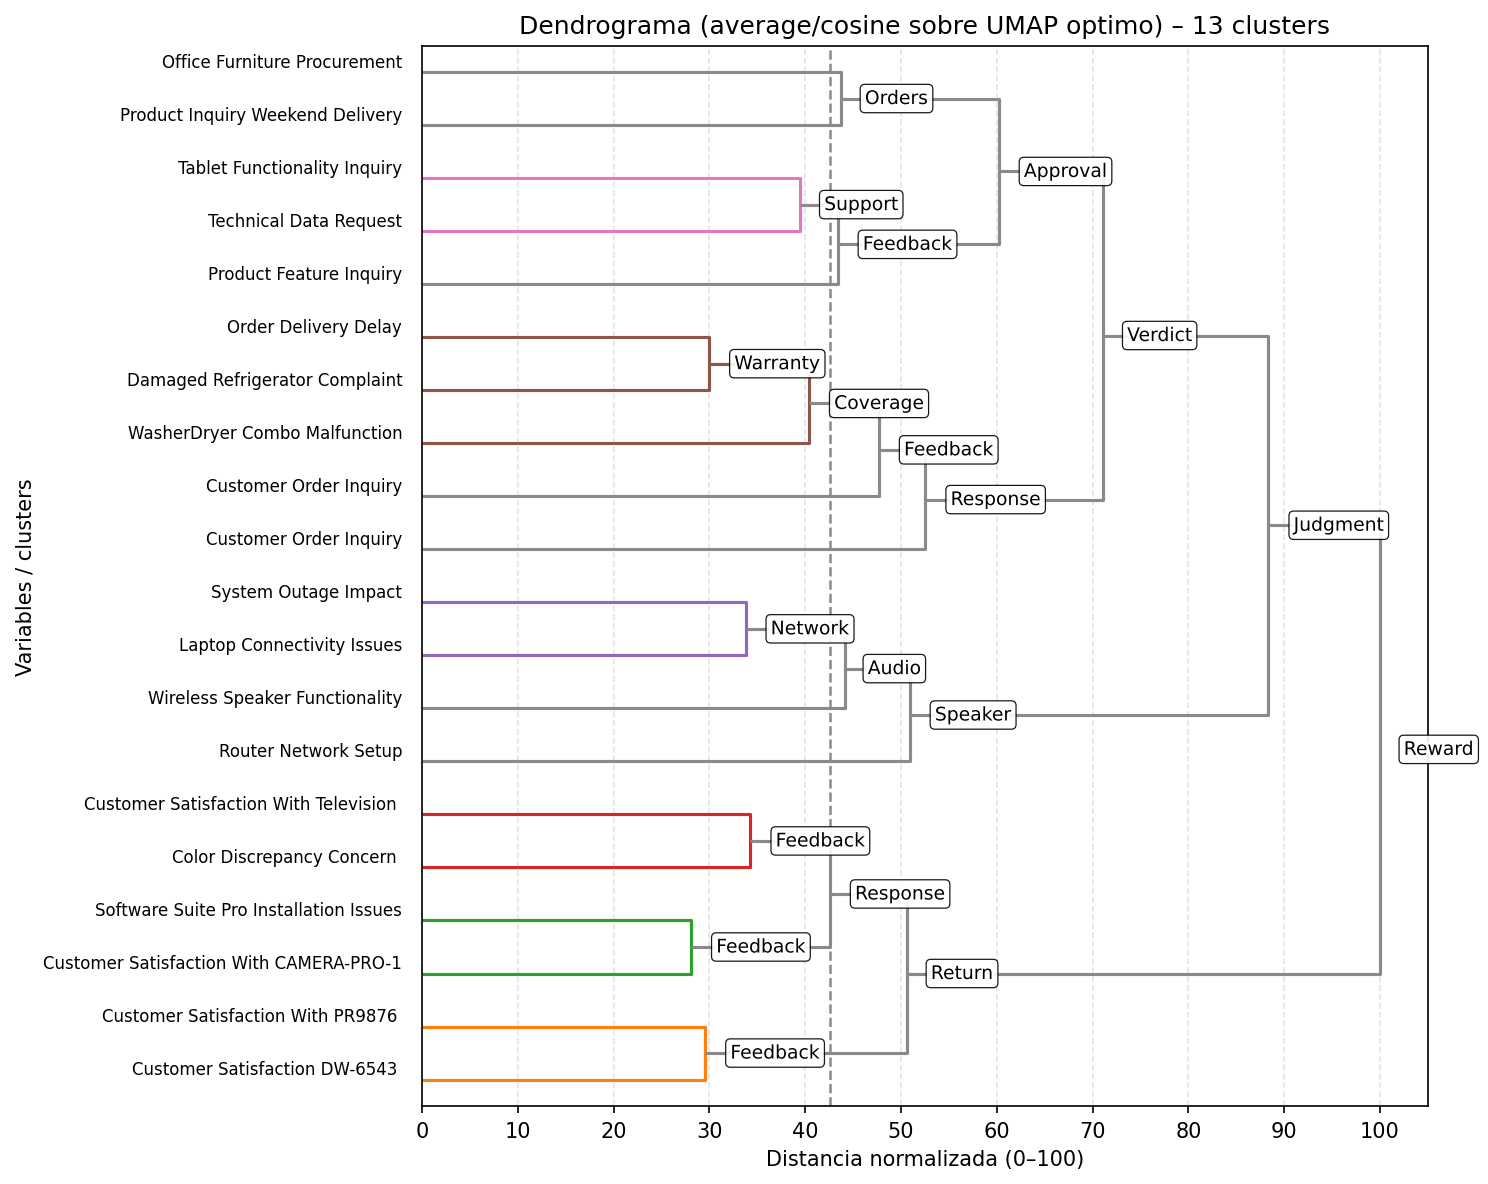

In [50]:
# Dendrograma horizontal con labels internos (estilo compacto)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, fcluster

k = 13  # numero de clusters

# --- clustering jerarquico ---
model = AgglomerativeClustering(
    distance_threshold=0, n_clusters=None,
    linkage='average', metric='cosine',
    compute_distances=True
).fit(low_dimension_opt)

n = len(model.labels_)
counts = np.zeros(model.children_.shape[0])
for i, merge in enumerate(model.children_):
    cnt = 0
    for m in merge:
        cnt += 1 if m < n else counts[m - n]
    counts[i] = cnt

dist = model.distances_.copy()
dist = np.power(dist, 0.1)
dist = (dist / dist.max()) * 100.0  # normalizamos 0–100

Z = np.column_stack([model.children_, dist, counts]).astype(float)

t = n - k
color_th = dist[t]

labels_k = fcluster(Z, t=color_th, criterion='distance')
print("clusters unicos:", len(np.unique(labels_k)))

# ---------- parametros de estilo (mas parecido al dendrograma sencillo) ----------
FIGSIZE = (10, 8)       # grafica mas compacta
DPI = 150
LEAF_FONT = 8
LEAF_ROT = 0
INTERNAL_FONT = 9
BOX_ALPHA = 0.90
STROKE_W = 2.0
X_OFFSET = 2.0          # que tanto se aleja el recuadro del nodo
EXTRA_OFFSET_PER_CHAR = 0.08
MAX_LABEL_LEN = 20
ANNOTATE_MIN_X = 0.0

def _shorten(s, n=MAX_LABEL_LEN):
    s = str(s)
    return s if len(s) <= n else (s[:n-1] + "…")

plt.rcParams['figure.dpi'] = DPI
fig, ax = plt.subplots(figsize=FIGSIZE)

# ---------- dendrograma horizontal ----------
ddata = dendrogram(
    Z,
    labels=labels_calls,
    orientation='right',        # igual que el sencillo
    leaf_font_size=LEAF_FONT,
    distance_sort='ascending',
    color_threshold=color_th,
    above_threshold_color='#8a8a8a',
)

# linea vertical del umbral
ax.axvline(color_th, ls='--', lw=1.2, c='#8a8a8a')

# labels de hojas
for tlabel in ax.get_yticklabels():
    tlabel.set_rotation(LEAF_ROT)
    tlabel.set_va('center')

ax.set_xlim(0, 105)   # un poco mas para que quepan los recuadros
ax.set_xticks(np.arange(0, 101, 10))
ax.grid(axis='x', linestyle='--', alpha=0.35)
ax.set_title(f"Dendrograma (average/cosine sobre UMAP optimo) – {k} clusters")
ax.set_xlabel("Distancia normalizada (0–100)")
ax.set_ylabel("Variables / clusters")

# ---------- posiciones de nodos para anotar ----------
leaf_order = ddata['leaves']
ypos_leaf = {leaf_idx: 5 + 10*i for i, leaf_idx in enumerate(leaf_order)}

children = model.children_.astype(int)
_node_y_cache = {}

def node_y(gidx: int) -> float:
    if gidx in _node_y_cache:
        return _node_y_cache[gidx]
    if gidx < n:
        y = ypos_leaf[gidx]
    else:
        a, b = children[gidx - n]
        y = 0.5 * (node_y(int(a)) + node_y(int(b)))
    _node_y_cache[gidx] = y
    return y

# ---------- anotamos labels internos del LLM ----------
for i in range(len(children)):
    gidx = n + i
    x = float(dist[i])
    if x < ANNOTATE_MIN_X:
        continue

    label = _shorten(node_label[gidx])  # viene de tu LLM
    if not label:
        continue

    y = node_y(gidx)
    x_txt = x + X_OFFSET + len(label) * EXTRA_OFFSET_PER_CHAR

    ax.text(
        x_txt, y, label,
        ha='left', va='center',
        fontsize=INTERNAL_FONT, rotation=0,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="black",
                  lw=0.6, alpha=BOX_ALPHA),
        path_effects=[pe.withStroke(linewidth=STROKE_W, foreground="white")]
    )

plt.tight_layout()
plt.show()


**Conclusion:**

**Este pipeline esta completo y nos ayuda a generar dendogramas, clusters en 2D, Clusters en High dimentions y nombrar los clusters.**